# Mediation analysis with sign-flipping and study wise zero-preserving quantile harmonization


## Imports and loading data


In [1]:
import numpy as np
from scipy.stats import rankdata
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from joblib import Parallel, delayed
from tqdm import tqdm

base_dir = '/Users/tspisak/data/PIC_conditioning_withinsub_nodatalad'
pheno = pd.read_csv(base_dir + '/signatures.csv')
orig_diff = nib.load(base_dir + '/all_data.nii')
mask = nib.load(base_dir + '/full_masked_10_percent.nii')

# convert x to categorical and get integer representation
pheno['plc_induction'] = pheno['Conditioning'].astype('category').cat.codes
pheno['Rating_diff'] = -1*pheno['Rating_diff']   # higher score stronger placebo

## Simple helper functions

In [2]:
def img2vector(image_4d, mask=None):
    """
    :param image_4d: 4d numpy.array of shape (nx, ny, nz, num_samples)
    :param mask: 3d numpy array (nx, ny, nz)
    :return: numpy.array (num_samples, n_within_mask_voxels)
    """
    if mask is not None:
        vectorized = image_4d[mask>0].transpose()
    else:
        vectorized = image_4d.reshape(-1, image_4d.shape[-1]).transpose()
    return vectorized
    
        
def vector2img(vectorized_data, out_shape, mask=None):
    """
    :param vectorized_data: (num_samples, n_features)
    :param out_shape: (nx, ny, nz, num_samples)
    :param mask: 3d numpy array (nx, ny, nz)
    :return: 4d numpy.array of shape (nx, ny, nz, num_samples)
    """
    nx, ny, nz, num_samples = out_shape
    if mask is not None:
        # Create an empty array with the desired output shape
        image_4d = np.zeros(out_shape)
        
        # Get the indices of the mask where the value is greater than 0
        mask_indices = np.where(mask > 0)
        
        # Reconstruct the image from the vectorized data
        for i in range(num_samples):
            temp_image = np.zeros((nx, ny, nz))
            temp_image[mask_indices] = vectorized_data[i]
            image_4d[:, :, :, i] = temp_image
    else:
        # If no mask is provided, reshape the data to the output shape
        image_4d = vectorized_data.T.reshape(out_shape)
    
    return image_4d

def vec2img3d(vectorized_data, mask):
    temp_image = np.zeros(mask.shape)
    temp_image[np.where(mask > 0)] = vectorized_data
    return temp_image

## Harmonization: zero-preserving quantile normalization

In [3]:
def rank_harmonize(data, batch_id, pb=False):
    """
    :param data: n_samples x n_features
    :param batch_id:  n_samples
    :param pb: switch progressbar on/off
    :return: within-batch zero preserving rank harmonized data
    """
    output = np.zeros(data.shape)
    pbar = tqdm(np.unique(batch_id), disable=not pb)
    for batch in pbar:
        pbar.set_description(f'Batch: {batch}')
        # get the data for this batch
        data_batch = data[batch_id == batch, :]
        # for each voxel, determine the ratio if participants with negative values
        ratio_neg = np.sum(data_batch<0, axis=0)/data_batch.shape[0]
        # do a normalized, zero-preserving rank transformation
        ranked = ((rankdata(data_batch, method='average', axis=0)-0.5)/data_batch.shape[0] - ratio_neg)
        output[batch_id == batch, :] = ranked
    pbar.set_description(f'Done!')
    return output

## Mask and vectorize data


In [4]:
data = img2vector(orig_diff.get_fdata(), mask=mask.get_fdata())
data.shape

(409, 191118)

## Harmonize data

In [5]:
rank_harmonized = rank_harmonize(data, pheno.Study_ID, pb=True)

Batch: zeidan: 100%|██████████| 16/16 [00:02<00:00,  5.59it/s]   


## Convert back and save

In [6]:
rank_harmonized_4d = vector2img(data, out_shape=orig_diff.get_fdata().shape, mask=mask.get_fdata())
# write back rank_harmonized to a 4d nifti
nib.save(nib.Nifti1Image(rank_harmonized_4d, orig_diff.affine), base_dir + '/all_data_studyranked.nii')

## Mediation analysis
*(see end of notebook for validation against pingouin)*

In [7]:
#                                                 M
#                                            (a) / \ (b)
#                                               /   \   
#                                              X ---- Y
#                                                (c)
# x, y: n_samples
# covar: n_samples x n_covariates
# m:  n_samples x n_features
def mediation(x, y, m, covar=None, y_type='continuous', m_type='continuous'):
    from sklearn.linear_model import LinearRegression, LogisticRegression
    from sklearn.multioutput import MultiOutputRegressor
    
    if covar is None:
        covar = np.array([])
        
    # M ~ X + covar
    if m_type == "continuous":
        XM = LinearRegression().fit(X=np.c_[x,covar], y=m).coef_[:,0]
    else:
        XM = MultiOutputRegressor(LogisticRegression()).fit(X=np.c_[x,covar], y=m).coef_[:,0]
        
    if y_type == "continuous":
        # Y ~ M + covar
        MY = np.array([LinearRegression().fit(X=np.c_[m[:,i],covar], y=y).coef_[0] for i in range(m.shape[1])])
        # Average Total Effects (Y ~ X + covar)
        XY = LinearRegression().fit(X=np.c_[x,covar], y=y).coef_[0]
        # Average Direct Effects (Y ~ X + M + covar)
        XMY_coefs = np.array([LinearRegression().fit(X=np.c_[x,m[:,i],covar], y=y).coef_ for i in range(m.shape[1])])
        
    else:
        MY = LogisticRegression().fit(X=np.c_[m,covar], y=y)    
    return XM * XMY_coefs[:, 1], XM, MY, XY, XMY_coefs[:, 2]    

In [8]:
%%time
ACME, XM, MY, XY, XMY = mediation(x=pheno['plc_induction'].to_numpy(),
                                  y=pheno['Rating_diff'].to_numpy(),
                                  m=rank_harmonized,
                                  covar = pheno[['Age','Male']].to_numpy(),
                                  m_type='continuous')

CPU times: user 1min 9s, sys: 6.76 s, total: 1min 16s
Wall time: 1min 9s


In [9]:
ACME

array([-0.06542304, -0.02941457, -0.1509606 , ...,  0.04381365,
        0.04788685,  0.03241497])

## Create workhorse function for sign-flipping

In [10]:
# bootstrap within studies
def signflip_workhorse(data, pheno, stat_fun, random_state=None):
    """
    Generates a single sign-flipped sample from data and pheno, assumes symmetric errors.
    Then calls stat_fun with the sign-flipped data and pheno variables.
    :param data: numpy array of shape (n_samples, n_features)
    :param pheno: pandas dataframe of shape (n_samples,n_phenotypes)
    :param stat_fun: function to be called with the bootstrapped sample. It is aware of pheno columns.
    :param random_seed: int or None, random seed for reproducibility
    :return: whatever stat_fun returns on the bootstrapped sample
    """
    # Set the random seed in a thread-safe manner
    if random_state is not None:
        random = np.random.RandomState(random_state)   
    # sign-flip random participants and
    # call the stat_fun with the sign-flipped data, pheno is unchanged
    return stat_fun(data * random.choice((-1,1), data.shape[0]).reshape(-1,1), pheno)

## Run sign-flipping

In [11]:
%%time

def stat_fun(data, pheno):
    rank_harmonized = rank_harmonize(data, pheno.Study_ID, pb=False)
    return mediation(x=pheno['plc_induction'].to_numpy(),
                     y=pheno['Rating_diff'].to_numpy(),
                     m=rank_harmonized,
                     covar = pheno[['Age','Male']].to_numpy(),
                     m_type='continuous')


seed = 42 # for reproducibility
n_perm = 1000

null_ACME, null_XM, null_MY, null_XY, null_XMY = zip(* Parallel(n_jobs=-1, timeout=99999)(delayed(
    signflip_workhorse)(data, pheno, stat_fun, [i, seed]) for i in range(n_perm)))

# save boot_ACME, boot_XM, boot_MY, boot_XY, boot_XMY
null_dist = {
    "PathA(XM)": np.array(null_XM),
    "PathB(MY)": np.array(null_MY),
    "Total(XY)": np.array(null_XY),
    "Indirect(ACME)": np.array(null_ACME),
    "Direct(Total-Indirect)": np.array(null_XY)[:, np.newaxis] - np.array(null_ACME),
}
np.save(base_dir + '/mediation_signflipped_null_dist.npy', null_dist)

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 14 s, sys: 14 s, total: 28 s
Wall time: 1h 51min 12s


In [12]:
null_dist = np.load(base_dir + '/mediation_signflipped_null_dist.npy', allow_pickle=True).item()

## Calculate more accurate small p-values with tail approximation
### Implementation of tail approximation

In [13]:
import scipy.stats as stats

def tail_approx(null_data, extreme_value, tail_ratios = (0.30, 0.25, 0.20, 0.15, 0.1), verbose=False):
    
    onetailed_pval = ((np.sum(null_data>=extreme_value)+1) 
                             / (null_data.shape[0] + 1))
    twotailed_pval = ((np.sum(np.abs(null_data)>=np.abs(extreme_value))+1) 
                             / (null_data.shape[0] + 1))
    
    # negate data if we need the lower tail
    if onetailed_pval > min(tail_ratios): # it's not in the right tail
        if onetailed_pval < 1 - min(tail_ratios): # it's not in the left tail
            return {'pval_original': twotailed_pval,
            'pval_pareto': twotailed_pval,
            'goodness_of_fit': np.nan,
            'tail_threshold': np.nan,
            'gpd_c': np.nan,
            'gpd_loc': np.nan,
            'gpd_scale': np.nan,
            'best_tail_ratio': np.nan
            }
        else: # it's in the lower tail, we must flip the distribution
            null_data *= -1
            extreme_value *= -1
    # else it's in the right tail, nothing to do
        
    if verbose:
        print(f"One-tailed p-value {onetailed_pval}")
    # tails can vary, get the best fit
    best_threshold = np.nan
    best_tail_ratio = None
    best_pval = np.inf
    best_gof = -1
    best_c = np.nan
    best_loc = np.nan
    best_scale = np.nan
    for tail_ratio in tail_ratios:
        # identify tail threshold
        threshold = np.quantile(null_data, 1-tail_ratio)
        # Identify the upper tail
        tail_data = null_data[null_data > threshold]
        # Fit the Generalized Pareto Distribution (GPD)
        c, loc, scale = stats.genpareto.fit(tail_data - threshold)
        # calculate the p-value
        excess_value = extreme_value - threshold
        p_value = (1 - stats.genpareto.cdf(excess_value, c, loc=loc, scale=scale)) * tail_ratio # we mltiply by the tail ratio to account for the fact that we only consider the tail
        
        # get the KS stat
        gof = stats.goodness_of_fit(stats.genpareto ,tail_data, known_params={'c': c,
                                                                        'loc': loc, 
                                                                        'scale': scale}, 
                                     random_state=42,
                                     statistic='ks').statistic
        
        if verbose:
            print(f"P-value with tail ratio {tail_ratio}: {p_value}     Goodness-of-fit: {gof}")
        
        if gof > best_gof:
            best_gof = gof
            best_threshold = threshold
            best_pval = p_value
            best_c = c
            best_loc = loc
            best_scale = scale
            best_tail_ratio = tail_ratio
            
    if best_pval == 0: # handle underflow
        best_pval = np.finfo(np.float64).tiny
            
    if verbose:
        # Plot the distribution of bootstrap correlations
        plt.hist(null_data, bins=30, edgecolor='k', alpha=0.7, density=True)
        plt.title('Tail Approximation')
        plt.xlabel('Test Statistic')
        plt.ylabel('Frequency')
            
        # Plot the fitted GPD versus the empirical tail data
        x = np.linspace(best_threshold, np.max((null_data.max(), extreme_value)), 100)
        y = stats.genpareto.pdf(x - best_threshold, best_c, loc=best_loc, scale=best_scale)
        plt.plot(x, y*best_tail_ratio, 'r-', lw=2, label='Fitted GPD')
        plt.axvline(extreme_value, color='r')
        
    return {'pval_original': twotailed_pval,
            'pval_pareto': best_pval*2,
            'goodness_of_fit': best_gof,
            'tail_threshold': best_threshold,
            'gpd_c': best_c,
            'gpd_loc': best_loc,
            'gpd_scale': best_scale,
            'best_tail_ratio': best_tail_ratio
            }


One-tailed p-value 0.984015984015984
P-value with tail ratio 0.3: 0.014783495272630863     Goodness-of-fit: 0.30524266754924584
P-value with tail ratio 0.25: 0.014802040311880371     Goodness-of-fit: 0.379068268702351
P-value with tail ratio 0.2: 0.016950670799765376     Goodness-of-fit: 0.4461667918440342
P-value with tail ratio 0.15: 0.015099603129281096     Goodness-of-fit: 0.594453229610959
P-value with tail ratio 0.1: 0.016608337529215356     Goodness-of-fit: 0.674990344609306


{'pval_original': 0.03696303696303696,
 'pval_pareto': 0.03321667505843071,
 'goodness_of_fit': 0.674990344609306,
 'tail_threshold': 0.16240779655271337,
 'gpd_c': -0.12733664647409176,
 'gpd_loc': 0.0012121421365339515,
 'gpd_scale': 0.15509051537673924,
 'best_tail_ratio': 0.1}

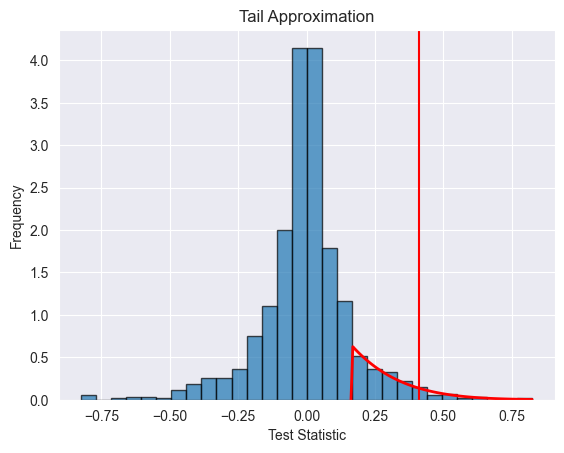

In [14]:
# test it
tail_approx(null_dist['Indirect(ACME)'][:,50722], ACME[50722], verbose=True)

## Do tail approximation for all voxels

In [17]:
from scipy.stats import false_discovery_control

observed = {
    "PathA(XM)": XM,
    "PathB(MY)": MY,
    "Total(XY)": XY,
    "Indirect(ACME)": ACME,
    "Direct(Total-Indirect)": XY - ACME,
}

tail_approximated = {}
fdr_qvals = {}

for key in null_dist.keys():
    print(f'Calculating FDR q-values for {key}')
    if key=='Total(XY)': #no voxel data:
        continue
    tail_approximated[key] = pd.DataFrame(
        Parallel(n_jobs=-1, timeout=99999)(delayed(tail_approx)(null_dist[key][:,vox_idx],
                                                                    observed[key][vox_idx]) for vox_idx in range(null_dist[key].shape[1]))
        )
    fdr_qvals[key] = false_discovery_control(tail_approximated[key].pval_pareto, method="bh")


Calculating FDR q-values for PathA(XM)


/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Calculating FDR q-values for PathB(MY)
Calculating FDR q-values for Total(XY)
Calculating FDR q-values for Indirect(ACME)
Calculating FDR q-values for Direct(Total-Indirect)


## Save results as nifiti files

*(See visualization in separate notebook)*

In [19]:
import os
out_dir = base_dir + '/mediation_signflipped_quantile0'
os.makedirs(out_dir, exist_ok=True)
# save results
for key in fdr_qvals.keys():
    print(key, np.min(fdr_qvals[key]), np.sum(fdr_qvals[key] < 0.05))
    # coefficient map
    nib.save(nib.Nifti2Image(vec2img3d(observed[key], mask.get_fdata()), affine=mask.affine),
             out_dir + F'/beta_{key}.nii.gz')
    # -log uncorrp
    nib.save(nib.Nifti2Image(vec2img3d(-np.log10(tail_approximated[key].pval_original), mask.get_fdata()), affine=mask.affine),
             out_dir + F'/uncorr_logp_{key}.nii.gz')
    # -log fdrq
    nib.save(nib.Nifti2Image(vec2img3d(-np.log10(fdr_qvals[key]), mask.get_fdata()), affine=mask.affine),
             out_dir + F'/fdr_logq_{key}.nii.gz')
    # thresholded map
    res = np.zeros_like(fdr_qvals[key])
    res[tail_approximated[key].pval_original<0.01] = 1
    res[fdr_qvals[key]<0.05] = 2
    res[observed[key]<0] *= -1
    nib.save(nib.Nifti2Image(vec2img3d(res, mask.get_fdata()), affine=mask.affine),
             out_dir + F'/thres_{key}.nii.gz')

PathA(XM) 1.1493288261896739e-304 122
PathB(MY) 6.031938520428075e-305 304
Indirect(ACME) 5.670022209202391e-304 59
Direct(Total-Indirect) 4.252516656901793e-303 9


## Validate the implementation against pingouin

In [20]:
ACME, Xm, My, Xy, Xmy = mediation(x=pheno['plc_induction'].to_numpy(),
                                  y=pheno['Rating_diff'].to_numpy(),
                                  m=rank_harmonized,
                                  covar = pheno[['Age','Male']].to_numpy(),
                                  m_type='continuous')
pd.DataFrame({'Xm': [Xm[182]], 
              'My': [My[182]], 
              'Total': [Xy], 
              'Direct': [Xy-ACME[182]], 
              'Indirect': [ACME[182]]})

,Xm,My,Total,Direct,Indirect
0,-0.103466,-9.148401,2.194774,1.277521,0.917253


In [21]:
from pingouin import mediation_analysis
tmp=pheno
tmp['ex_voxel'] = rank_harmonized[:,182]

stats, dist = mediation_analysis(data=tmp, x='plc_induction', m='ex_voxel', y='Rating_diff',
                                 covar=['Age', 'Male'], 
                                 n_boot=10,
                                 alpha=0.05, seed=42, return_dist=True)
stats

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,ex_voxel ~ X,-0.103466,0.033562,0.002191,-0.169443,-0.037488,Yes
1,Y ~ ex_voxel,-9.148401,2.595576,0.000473,-14.250885,-4.045917,Yes
2,Total,2.194774,1.797240,0.222724,-1.338310,5.727858,No
3,Direct,1.277521,1.795334,0.477137,-2.251842,4.806884,No
4,Indirect,0.917253,0.282654,0.000000,0.334130,1.001161,Yes


## Visualize the harmonized data

<Axes: >

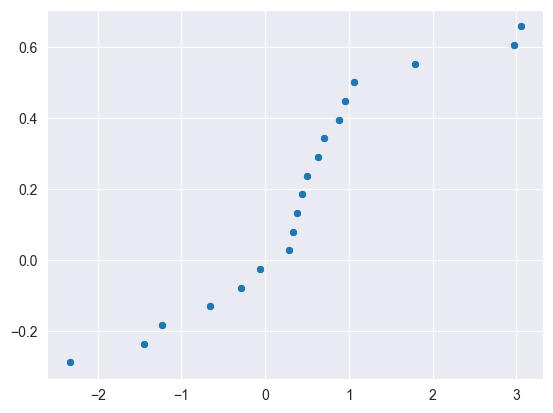

In [22]:
sns.scatterplot(x=data[pheno.Study_ID=='atlas', 100], y=rank_harmonized[pheno.Study_ID=='atlas', 100])

<Axes: >

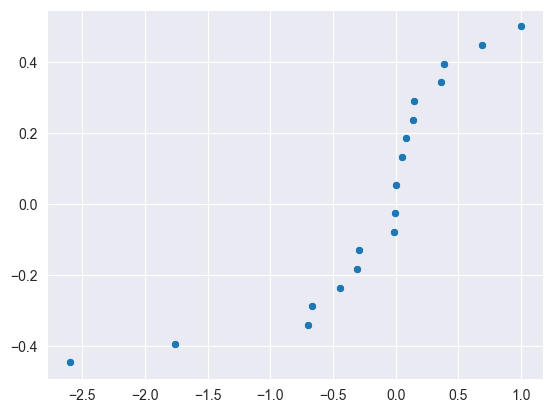

In [23]:
sns.scatterplot(x=data[pheno.Study_ID=='bingel06', 100], y=rank_harmonized[pheno.Study_ID=='bingel06', 100])

# Group-level analysis for path a
- with the same harmonization, we can do a group-mean and conjunction analysis for path A, to how the difference is composed

In [29]:
# x: n_samples
# covar: n_samples x n_covariates
# m:  n_samples x n_features
def group_means(x, m, covar=None, m_type='continuous'):
    from sklearn.linear_model import LinearRegression, LogisticRegression
    from sklearn.multioutput import MultiOutputRegressor
    
    if covar is None:
        covar = np.array([])
        
    # Difference: M ~ X + covar
    if m_type == "continuous":
        XM= LinearRegression().fit(X=np.c_[x,covar], y=m)
    else:
        XM = MultiOutputRegressor(LogisticRegression()).fit(X=np.c_[x,covar], y=m).coef_[:,0]
        
    group_diff = XM.coef_[:,0]
    group0_mean = XM.intercept_  # we assume dummy coding, i.e. group 0 is the reference group
    group1_mean = XM.intercept_ + group_diff
    # conjunction analysis
    min_group_effect = np.min((group0_mean, group1_mean), axis=0) # for conjunction analysis with global null
           
    return group_diff, group0_mean, group1_mean, min_group_effect 

In [30]:
%%time
group_diff, group0_mean, group1_mean, min_group_effect  = group_means(x=pheno['plc_induction'].to_numpy(),
                                                      m=rank_harmonized,
                                                      covar = pheno[['Age','Male']].to_numpy(),
                                                      m_type='continuous')

CPU times: user 1.21 s, sys: 3.73 s, total: 4.94 s
Wall time: 736 ms


In [ ]:
%%time

def stat_fun(data, pheno):
    rank_harmonized = rank_harmonize(data, pheno.Study_ID, pb=False)
    return group_means(x=pheno['plc_induction'].to_numpy(),
                       m=rank_harmonized,
                       covar = pheno[['Age','Male']].to_numpy(),
                       m_type='continuous')


seed = 42 # for reproducibility
n_perm = 16 #1000

null_group_diff, null_group0_mean, null_group1_mean, min_group_effect = zip(* Parallel(n_jobs=-1, timeout=99999)(delayed(
    signflip_workhorse)(data, pheno, stat_fun, [i, seed]) for i in range(n_perm)))

# save boot_ACME, boot_XM, boot_MY, boot_XY, boot_XMY
null_dist = {
    "CONDINSTgtINST": np.array(null_group_diff),
    "meanINST": np.array(null_group0_mean),
    "meanCOND": np.array(null_group1_mean),
    "INSTandCONDINST": np.array(min_group_effect),
}
np.save(base_dir + '/mediation_signflipped_null_dist_pathA.npy', null_dist)